In [2]:
default_headers = {
          'Content-Type': 'application/json',
          'Access-Control-Allow-Origin': '*'
        }

In [3]:
from IPython.display import display_javascript, display_html, display
import uuid

class RenderJSON(object):
    def __init__(self, json_data):
        if isinstance(json_data, dict):
            self.json_str = json.dumps(json_data)
        elif isinstance(json_data, list):
            self.json_str = json.dumps(json_data)
        else:
            self.json_str = json
        self.uuid = str(uuid.uuid4())
        
    def _ipython_display_(self):
        display_html('<div id="{}" style="height: 150px; width:100%;"></div>'.format(self.uuid),
            raw=True
        )
        display_javascript("""
        require(["https://rawgit.com/caldwell/renderjson/master/renderjson.js"], function() {
          document.getElementById('%s').appendChild(renderjson(%s))
        });
        """ % (self.uuid, self.json_str), raw=True)

In [4]:
import requests, json

In [5]:
engine = "http://jasper:8181"

In [6]:
e = requests.get(engine + "/jasper").json()

In [7]:
RenderJSON(e)

In [8]:
l = requests.get(engine + "/jasper/streams").json()

In [9]:
RenderJSON(l)

In [10]:
qs = requests.get(engine + "/jasper/queries").json()

In [11]:
RenderJSON(qs)

In [12]:
redstream = requests.get("http://redstream:1255/red")

In [13]:
RenderJSON(redstream.json())

In [17]:
body = {
    'id':'greencount',
    'tbox': 'https://raw.githubusercontent.com/riccardotommasini/colorwave/master/colors.owl',
    'format': 'JSON',
    'body': '''
        SELECT (COUNT(?r) as ?numGreen)
        FROM NAMED WINDOW <rw> ON <http://greenstream:2255/green> [RANGE PT15S STEP PT5S]
        WHERE {
                WINDOW ?rw { ?r a <http://www.streamreasoning.org/ontologies/2018/9/colors#Green> .}
            }

    '''
}
    
data = json.dumps(body)

RenderJSON(body)

In [18]:
q = requests.post(engine + "/jasper/queries", data = data, headers=default_headers)

In [19]:
q.text

'{\n  "@id" : "queries/greencount",\n  "@type" : "vprov:Task",\n  "prov:generated" : {\n    "@id" : "streams/greencount"\n  },\n  "prov:uses" : {\n    "@id" : "http://greenstream:2255/green"\n  },\n  "@context" : {\n    "@base" : "http://jasper:8181/jasper/",\n    "rdf" : "http://www.w3.org/1999/02/22-rdf-syntax-ns#",\n    "vsd" : "http://w3id.org/rsp/vocals-sd#",\n    "vocals" : "http://w3id.org/rsp/vocals#",\n    "xsd" : "http://www.w3.org/2001/XMLSchema#",\n    "format" : "http://www.w3.org/ns/formats/",\n    "rdfs" : "http://www.w3.org/2000/01/rdf-schema#",\n    "vprov" : "http://w3id.org/rsp/vocals-prov#",\n    "dcat" : "http://www.w3.org/ns/dcat#",\n    "prov" : "http://www.w3.org/ns/prov#"\n  }\n}'

In [16]:
RenderJSON(q.json())

In [20]:
o = requests.post(engine + "/jasper/observers/greencount", data = json.dumps({'protocol':"HTTP", "retention":5}) , headers=default_headers).json()

In [21]:
os = requests.get(engine + "/jasper/observers/greencount").json()

In [22]:
RenderJSON(o)

In [23]:
RenderJSON(os)

In [24]:
a = requests.get("http://jasper:8188/jasper/streams/greencount/observers/1322951247")

In [27]:
a.json()

[]

In [25]:
import pandas as pd
b = a.json()[0]
b

IndexError: list index out of range

In [95]:
from pandas.io.json import json_normalize
def flatten_json(y):
    out = {}

    def flatten(x, name=''):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x

    flatten(y)
    return out

In [96]:
def coerce_df_columns_to_numeric(df, column_list):
    df[column_list] = df[column_list].apply(pd.to_numeric, errors='coerce')

In [102]:
data = [flatten_json(b) for b in a.json()]
df = pd.DataFrame.from_dict(data, orient='columns')
coerce_df_columns_to_numeric(df, ['results_bindings_0_numRed_value'])

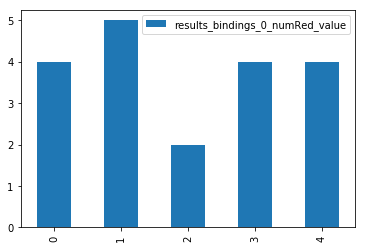

In [104]:
% matplotlib inline
df.plot(kind='bar')

In [60]:
o = requests.post(engine + "/jasper/observers/redcount", data = json.dumps({'protocol':"WEBSOCKET"}) , headers=default_headers).json()

In [84]:
RenderJSON(o)